In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, model_selection, pipeline, compose
from sklearn.metrics import (
    classification_report,
    recall_score,
    make_scorer,
    precision_recall_curve,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
)

CONFIGS

In [2]:
# Optional: Try importing XGBoost
try:
    from xgboost import XGBClassifier

    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("Warning: XGBoost not installed. Run `pip install xgboost` if you want to use it.")
# MODEL SELECTION SWITCH
# Set this to True to use XGBoost, False for Random Forest
USE_XGBOOST = False

# Seeds
RANDOM = 42

# Folders (Adjust as needed)
ROOT = Path("../data")
DATA = str(ROOT / "processed")
CACHE = str(ROOT / ".cache")

# Input Files (Pre-Split)
INPUTS_TRAIN_FILE = f"{DATA}/inputs_train.parquet"
INPUTS_TEST_FILE = f"{DATA}/inputs_test.parquet"
TARGETS_TRAIN_FILE = f"{DATA}/targets_train.parquet"
TARGETS_TEST_FILE = f"{DATA}/targets_test.parquet"

# Feature Definition
GROUP_COL = "user_id"  # for Cross-Validation grouping

# Scoring
SCORING = make_scorer(recall_score, pos_label=1)  # Focus on Recall for Positive Class

# Hyperparameter Search Grid
# OPTION A: Random Forest Grid
RF_GRID = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [
        7,
        10,
        12,
        15,
    ],  # deeper trees may capture rare fatigue patterns, increasing recall
    "regressor__min_samples_split": [10, 15, 20, 25],
    "regressor__min_samples_leaf": [1, 2, 4, 8],  # Allow smaller leaves may increase recall
    "regressor__max_features": ["sqrt"],  # Standard for RF
    "regressor__bootstrap": [True],  # add randomness to improve generalization
}

# OPTION B: XGBoost / Gradient Boosting Grid (Different params!)
XGB_GRID = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.05, 0.1],  # Crucial for Boosting (not in RF)
    "classifier__max_depth": [3, 4, 5],  # Boosting needs shallow trees
    "classifier__subsample": [0.8, 1.0],  # Stochastic gradient boosting
    "classifier__colsample_bytree": [0.8, 1.0],  # Fraction of features per tree
}

# SELECT ACTIVE MODEL
ACTIVE_GRID = RF_GRID  # Change to XGB_GRID if switching models

# DATA LOADING

In [3]:
print("Loading pre-split Parquet files...")
inputs_train = pd.read_parquet(INPUTS_TRAIN_FILE)
targets_train = pd.read_parquet(TARGETS_TRAIN_FILE)

inputs_test = pd.read_parquet(INPUTS_TEST_FILE)
targets_test = pd.read_parquet(TARGETS_TEST_FILE)

print(f"[TRAIN] Inputs: {inputs_train.shape} | Targets: {targets_train.shape}")
print(f"[TEST]  Inputs: {inputs_test.shape} | Targets: {targets_test.shape}")

Loading pre-split Parquet files...
[TRAIN] Inputs: (1032, 13) | Targets: (1032, 1)
[TEST]  Inputs: (306, 13) | Targets: (306, 1)


# PREPARE GROUPS FOR CV

In [4]:
if GROUP_COL not in inputs_train.columns:
    raise ValueError(f"Column '{GROUP_COL}' missing from inputs_train! Needed for GroupKFold.")

groups_train = inputs_train[GROUP_COL]

In [5]:
# IMPORTANT:  User ID was dropped from the features used for training
# so the model doesn't memorize specific User IDs.
X_train = inputs_train.drop(columns=[GROUP_COL])
X_test = inputs_test.drop(columns=[GROUP_COL])

# Identify remaining features
features_in = X_train.columns.tolist()
print(f"Features used for training: {features_in}")

Features used for training: ['mean_hr_5min', 'hr_volatility_5min', 'hr_jumpiness_5min', 'hr_mean_total', 'hr_std_total', 'stress_cv', 'hours_awake', 'cum_sleep_debt', 'sleep_inertia_idx', 'circadian_sin', 'circadian_cos', 'hr_zscore']


# MODEL PIPELINE

In [6]:
# MODEL SELECTION LOGIC
if USE_XGBOOST and XGB_AVAILABLE:
    print("\n>>> SELECTED MODEL: XGBoost Classifier")
    clf = XGBClassifier(
        random_state=42, n_jobs=-1, objective="binary:logistic", eval_metric="logloss"
    )
    param_grid = XGB_GRID
else:
    print("\n>>> SELECTED MODEL: Random Forest Classifier")
    rg = ensemble.RandomForestRegressor(random_state=42, n_jobs=-1)
    param_grid = RF_GRID

# Build Pipeline
model_pipeline = pipeline.Pipeline(
    steps=[
        (
            "transformer",
            compose.ColumnTransformer(
                [("numericals", "passthrough", features_in)], remainder="drop"
            ),
        ),
        ("regressor", rg),
    ],
    memory=CACHE,
)


>>> SELECTED MODEL: Random Forest Classifier


TUNING (STAGE 1)

In [7]:
print("\nStarting Grid Search with GroupKFold...")

search = model_selection.GridSearchCV(
    estimator=model_pipeline,
    cv=model_selection.GroupKFold(n_splits=5),  # 5-Fold CV respecting User Groups
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

print("Starting Hyperparameter Tuning...")
search.fit(X_train, targets_train, groups=groups_train)

print(f"Best Params: {search.best_params_}")
best_model = search.best_estimator_


Starting Grid Search with GroupKFold...
Starting Hyperparameter Tuning...
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/Users/amyshih/Desktop/python/fatigue_prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/amyshih/Desktop/python/fatigue_prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/amyshih/Desktop/python/fatigue_prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/amyshih/Desktop/python/fatigue_prediction/.venv/lib/python3.9/site-pa

Best Params: {'regressor__bootstrap': True, 'regressor__max_depth': 12, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 15, 'regressor__n_estimators': 100}


/Users/amyshih/Desktop/python/fatigue_prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


setting the alert theshold

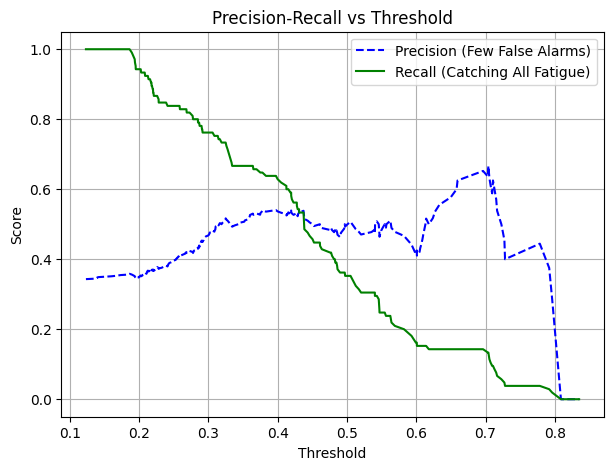

In [8]:
# 1. Predict on the TEST set (Unseen Users)
y_test = targets_test
y_pred_proba = best_model.predict(X_test)

# 2. Binarize the actual test targets for evaluation
# (Assuming actual target > 0.5 is "Fatigued" for Ground Truth validation)
# Adjust this threshold if your target definition of fatigue is stricter
y_test_binary = (y_test > 0.5).astype(int)

# 3. Calculate Precision/Recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test_binary, y_pred_proba)

# 4. Plot
plt.figure(figsize=(7, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Few False Alarms)")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Catching All Fatigue)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Precision-Recall vs Threshold")
plt.grid(True)
plt.show()

In [9]:
# --- A. Regression Evaluation (The Raw Score) ---
mse = mean_squared_error(y_test, y_pred_proba)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred_proba)
print("--- Regression Performance ---")
print(f"RMSE: {rmse:.4f} (Lower is better)")
print(f"MAE:  {mae:.4f} (Average deviation from truth)")

--- Regression Performance ---
RMSE: 0.3311 (Lower is better)
MAE:  0.2757 (Average deviation from truth)


In [10]:
# --- Classification Evaluation (The Alert System) ---
# Pick the threshold you decided on from the PR Curve
CHOSEN_THRESHOLD = 0.315

y_pred_alert = (y_pred_proba >= CHOSEN_THRESHOLD).astype(int)
y_true_alert = (y_test >= 0.5).astype(int)  # Assuming 0.5+ is actual fatigue

print(f"\n--- Classification Performance (Threshold {CHOSEN_THRESHOLD}) ---")
print(f"ROC-AUC Score: {roc_auc_score(y_true_alert, y_pred_proba):.4f}")
print("\nDetailed Report:")
print(classification_report(y_true_alert, y_pred_alert, target_names=["Awake", "Fatigued"]))


--- Classification Performance (Threshold 0.315) ---
ROC-AUC Score: 0.6730

Detailed Report:
              precision    recall  f1-score   support

       Awake       0.82      0.61      0.70       201
    Fatigued       0.50      0.74      0.60       105

    accuracy                           0.66       306
   macro avg       0.66      0.68      0.65       306
weighted avg       0.71      0.66      0.67       306



In [12]:
# --- Inspecting the "Worst Misses" ---
# Let's look at the most dangerous cases: User was Fatigued (1.0), but Model said Awake (<0.3)
results_df = X_test.copy()
results_df["Actual"] = y_test.values
results_df["Predicted"] = y_pred_proba

print("\n--- Top 5 Dangerous Misses (Actual=Fatigued, Predicted=Safe) ---")
dangerous_misses = results_df[results_df["Actual"] > 0.8].sort_values("Predicted").head(5)
print(dangerous_misses[["Actual", "Predicted", "mean_hr_5min", "hours_awake"]])


--- Top 5 Dangerous Misses (Actual=Fatigued, Predicted=Safe) ---
     Actual  Predicted  mean_hr_5min  hours_awake
83      1.0   0.186096     -0.650965    -0.480003
80      1.0   0.189340     -0.651816    -0.480003
81      1.0   0.189340     -0.653857    -0.480003
514     1.0   0.193532      0.890168     1.149006
515     1.0   0.193938      0.830990     1.149006


feature importance

In [25]:
print(feature_imp_df.head(10))

              Feature  Importance
9       circadian_sin    0.183110
8   sleep_inertia_idx    0.164686
6         hours_awake    0.138834
3       hr_mean_total    0.088811
7      cum_sleep_debt    0.081402
0        mean_hr_5min    0.075701
4        hr_std_total    0.071068
10      circadian_cos    0.066985
11          hr_zscore    0.047273
2   hr_jumpiness_5min    0.037562


/var/folders/fc/ypbtcn852k18_8vzfz6fqd_h0000gn/T/ipykernel_1716/2173838922.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_imp_df, palette="viridis")


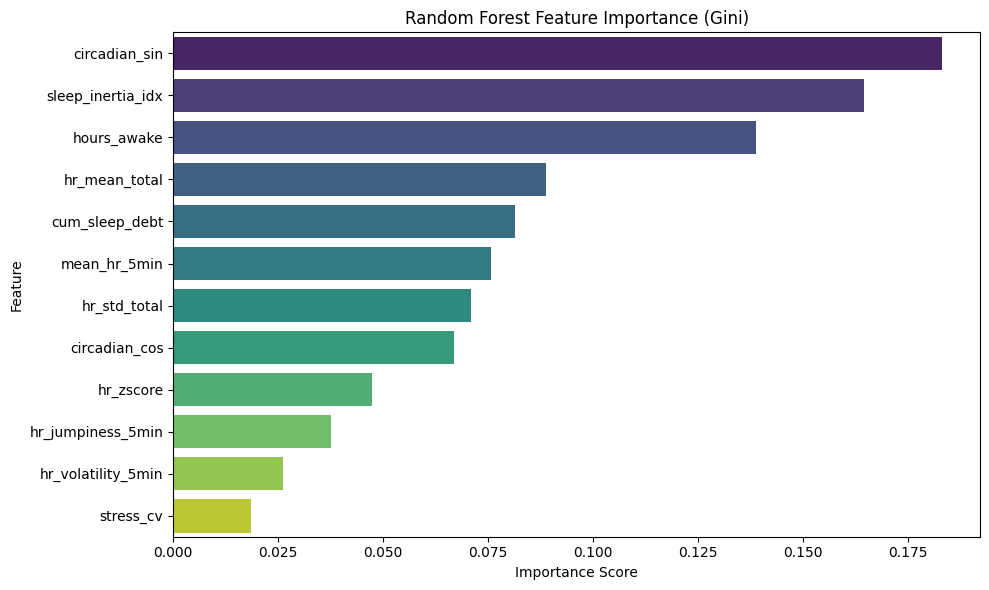

               Feature  Importance
9        circadian_sin    0.183110
8    sleep_inertia_idx    0.164686
6          hours_awake    0.138834
3        hr_mean_total    0.088811
7       cum_sleep_debt    0.081402
0         mean_hr_5min    0.075701
4         hr_std_total    0.071068
10       circadian_cos    0.066985
11           hr_zscore    0.047273
2    hr_jumpiness_5min    0.037562
1   hr_volatility_5min    0.026067
5            stress_cv    0.018501


In [24]:
rf_model = best_model.named_steps["regressor"]
# Get the scores
importances = rf_model.feature_importances_

# 'create a DataFrame for better visualization
feature_imp_df = pd.DataFrame({"Feature": features_in, "Importance": importances}).sort_values(
    by="Importance", ascending=False
)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_imp_df, palette="viridis")
plt.title("Random Forest Feature Importance (Gini)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 5. Print top features
print(feature_imp_df)